# Convertible Bond Pricing & Option-Market Calibration (Reduced Form + ragtop)


This notebook implements the end-to-end workflow requested for the convertible bond study. We:

* Bootstrap the risk-free term structure from supplied node data and build reusable discounting helpers.
* Implement reduced-form equity dynamics with jump-to-default hazard as described by Boonstra (2016) and Andersen & Buffum (2002).
* Compare vanilla Black–Scholes option prices with a jump-to-default (JtD) effective-dividend shortcut, then calibrate `(σ, b, p)` on a coarse grid using three option quotes.
* Build a finite-difference (FD) PDE solver (Crank–Nicolson with Rannacher start and an obstacle policy iteration) for a 2-year convertible bond with state-dependent hazard, recovery, and early conversion.
* Run constant-hazard sanity checks, grid search calibration, optional differential-evolution refinement, CB valuation across several parameter sets, and sensitivity to spot.

Throughout we keep the workflow reproducible, annotate each section with references to the readings, and assert numerical sanity checks (discount monotonicity, option parity, CB bounds, and monotonicity in `S`).


In [22]:
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq

import ragtop
from ragtop.blackscholes import black_scholes

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

# Global runtime switches
RUN_HEAVY = True      # gate calibration loops and FD grids
SAVE_ARTIFACTS = True
VERBOSE = True

ART_DIR = Path("../artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)

# Backward-compat alias if you had an older notebook using RUN_SLOW
RUN_SLOW = RUN_HEAVY

# Sanity check: ragtop Black–Scholes signature matches expectations.
# _test_px = black_scholes(-1, 625, 612, 0.05, 0.75, 0.62, borrow_cost=0.011)
# assert abs(_test_px - 113.34) < 1e-2, f"ragtop black_scholes sanity check failed (got {_test_px:.4f})"


## 1. Market data snapshot

Risk-free rates are supplied as continuously-compounded spot rates (annualised).  
We interpolate linearly in maturity to recover \(r(t)\), discount factors, and average rates.


In [23]:
curve_df = pd.DataFrame(
    [
        (0.04988584, 0.004208395),
        (0.12659817, 0.004846041),
        (0.37591324, 0.007777790),
        (0.62522831, 0.009878801),
        (0.72111872, 0.010491200),
        (1.71837900, 0.010167270),
        (5.00000000, 0.020000000),
    ],
    columns=["time", "rate"],
)
curve_df


,time,rate
0,0.049886,0.004208
1,0.126598,0.004846
2,0.375913,0.007778
3,0.625228,0.009879
4,0.721119,0.010491
5,1.718379,0.010167
6,5.000000,0.020000


In [24]:
from scipy.interpolate import interp1d

_times = curve_df["time"].to_numpy()
_rates = curve_df["rate"].to_numpy()
_r_interp = interp1d(_times, _rates, kind="linear", fill_value="extrapolate", assume_sorted=True)


def r_of(t: float) -> float:
    """Piecewise-linear spot rate r(t)."""
    return float(_r_interp(np.clip(float(t), 0.0, float(_times[-1]))))


def _integral_rate(t: float) -> float:
    """Integral of r from 0 to t using trapezoidal integration on the linear curve."""
    t = float(t)
    if t <= 0.0:
        return 0.0
    knots = [0.0]
    knots.extend(float(x) for x in _times if x < t)
    if knots[-1] != t:
        knots.append(t)
    knots = np.asarray(knots)
    rates = np.array([r_of(k) for k in knots])
    return float(np.trapz(rates, knots))


def discount_factor(t: float) -> float:
    return float(np.exp(-_integral_rate(t)))


def average_rate(t: float) -> float:
    t = float(t)
    return r_of(0.0) if t <= 0.0 else _integral_rate(t) / t


# Cheap monotonicity sanity check
assert discount_factor(2.0) < discount_factor(1.0) < 1.0


C:\Users\Owner\AppData\Local\Temp\ipykernel_27620\1306845215.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(rates, knots))


### Equity, option quotes, and convertible terms

All instruments reference the same underlying equity with spot \(S_0 = 241.80\) and no dividends.  
Option maturities are aligned at \(T_{\mathrm{opt}} = 1.72\) years.

Convertible recovery inputs assume:

* `RECOVERY_BOND = 0.40` — fraction-of-notional recovery in default for the bond leg  
* `RECOVERY_EQUITY = 0.0` — equity is wiped out in default

This matches the reduced-form PDE source term \(\lambda R_b N\) used below.


In [25]:
S0 = 241.80
DIVIDEND_YIELD = 0.0
T_opt = 1.72

option_quotes = pd.DataFrame(
    [
        ("P230", -1, 230.0, 52.40, 51.35, 53.45),
        ("P150", -1, 150.0, 19.45, 17.90, 21.00),
        ("C370", +1, 370.0, 13.95, 13.00, 14.90),
    ],
    columns=["label", "callput", "K", "mid", "bid", "ask"],
)

NOTIONAL = 1_000.0
CONVERSION_RATIO = 3.84615  # conversion price 260
T_cb = 2.0
RECOVERY_BOND = 0.40
RECOVERY_EQUITY = 0.0
BORROW_COST_OPTION = 0.0

snapshot_rows = [
    ("Spot", "S0", S0),
    ("Option", "T_opt", T_opt),
    ("Convertible", "Notional", NOTIONAL),
    ("Convertible", "Conversion ratio", CONVERSION_RATIO),
    ("Convertible", "Tenor", T_cb),
    ("Convertible", "Recovery (bond)", RECOVERY_BOND),
    ("Convertible", "Recovery (equity)", RECOVERY_EQUITY),
]

snapshot_table = pd.DataFrame(snapshot_rows, columns=["category", "field", "value"])
option_quotes, snapshot_table


(  label  callput      K    mid    bid    ask
 0  P230       -1  230.0  52.40  51.35  53.45
 1  P150       -1  150.0  19.45  17.90  21.00
 2  C370        1  370.0  13.95  13.00  14.90,
       category              field       value
 0         Spot                 S0   241.80000
 1       Option              T_opt     1.72000
 2  Convertible           Notional  1000.00000
 3  Convertible   Conversion ratio     3.84615
 4  Convertible              Tenor     2.00000
 5  Convertible    Recovery (bond)     0.40000
 6  Convertible  Recovery (equity)     0.00000)

## 2. Part 1 — Constant-parameter pricing

We splice a constant hazard level (\(\lambda = 7.5\%\)) into the equity via a “dividend-like” adjustment and use
`ragtop.black_scholes` as the pricing and implied-volatility engine.

Each option is evaluated twice:

1. Default-free Black–Scholes with \(q = 0\).
2. A jump-to-default proxy with an effective dividend \(q_{\mathrm{eff}} = q + \lambda\).

This shortcut is **only** used for the listed options.  
The convertible itself is priced with the reduced-form PDE that includes the \((r+\lambda)\) kill term,
\(\lambda R_b N\) recovery source, and the early-conversion obstacle.


In [26]:
def bs_price(callput: int, S: float, K: float, T: float, r: float, borrow_cost: float, sigma: float) -> float:
    """Thin wrapper around ragtop.black_scholes."""
    return float(black_scholes(callput, K, S, r, T, sigma, borrow_cost=borrow_cost))


def implied_vol_with_ragtop(
    callput: int,
    S: float,
    K: float,
    T: float,
    r: float,
    price: float,
    *,
    borrow_cost: float = 0.0,
    tol: float = 1e-8,
) -> float:
    """Implied volatility via Brent's method on ragtop Black–Scholes."""
    if T <= 0 or price <= 0:
        return float("nan")

    def objective(sig: float) -> float:
        return bs_price(callput, S, K, T, r, borrow_cost, sig) - price

    low, high = 1e-4, 3.0
    f_low, f_high = objective(low), objective(high)
    if f_low * f_high > 0:
        # Price is outside BS range on this bracket
        return float("nan")
    return float(brentq(objective, low, high, xtol=tol, rtol=tol))


def default_intensity_fcn(t: float, S: float, b: float, p: float, Sref: float = S0) -> float:
    """
    Scalar hazard intensity lambda(t, S) at (t, S) for the “Boonstra-style” shape:

        λ(S) = 0.075 * [ b + (1 - b) * (Sref / S)^p ]

    with floor via S_safe to avoid division by zero.
    """
    S_safe = max(S, 1e-12)
    return 0.075 * (b + (1.0 - b) * (Sref / S_safe) ** p)


def hazard_lambda(S: np.ndarray, b: float, p: float, Sref: float = S0) -> np.ndarray:
    """Vectorised version λ(S) on a spot grid."""
    S_arr = np.asarray(S, dtype=float)
    safe = np.maximum(S_arr, 1e-12)
    return 0.075 * (b + (1.0 - b) * (Sref / safe) ** p)


In [28]:
def bs_price(callput: int, S: float, K: float, T: float, r: float, borrow_cost: float, sigma: float) -> float:
    """
    Thin wrapper around ragtop.black_scholes.

    Handles both:
      - old-style returns (plain float)
      - newer dict-like returns (e.g. {'price': ..., 'delta': ..., ...})
      - or objects with .price / .value attributes
    """
    raw = black_scholes(callput, K, S, r, T, sigma, borrow_cost=borrow_cost)

    # 1) Plain numeric (old behaviour)
    if isinstance(raw, (int, float)):
        return float(raw)

    # 2) Dict-like (common in newer ragtop versions)
    if isinstance(raw, dict):
        for key in ("price", "option_price", "value"):
            if key in raw:
                return float(raw[key])
        # Fallback: first numeric value if key names differ
        for v in raw.values():
            if isinstance(v, (int, float)):
                return float(v)
        raise TypeError(f"black_scholes returned dict without a numeric price field: {raw}")

    # 3) Object with attribute (e.g. dataclass / namedtuple-like)
    for attr in ("price", "option_price", "value"):
        if hasattr(raw, attr):
            return float(getattr(raw, attr))

    # If we got here, we genuinely don't know how to convert this
    raise TypeError(f"Unexpected black_scholes return type: {type(raw)} -> {raw}")

_test_px = black_scholes(-1, 625, 612, 0.05, 0.75, 0.62, borrow_cost=0.011)
print(type(_test_px))
print(_test_px)



<class 'dict'>
{'Price': np.float64(113.33695859930296), 'Delta': np.float64(-0.35569555195998925), 'Vega': np.float64(200.57079827363765)}


In [30]:
const_sigma = 0.50
const_lambda = 0.075
q_eff = DIVIDEND_YIELD + const_lambda
r_bar_opt = average_rate(T_opt)

rows = []
for quote in option_quotes.itertuples(index=False):
    bs_px = bs_price(quote.callput, S0, quote.K, T_opt, r_bar_opt, BORROW_COST_OPTION, const_sigma)
    jtd_px = bs_price(quote.callput, S0, quote.K, T_opt, r_bar_opt, q_eff, const_sigma)

    abs_err = jtd_px - quote.mid
    rel_err = abs_err / quote.mid if quote.mid else float("nan")

    bs_iv = implied_vol_with_ragtop(
        quote.callput, S0, quote.K, T_opt, r_bar_opt, quote.mid, borrow_cost=BORROW_COST_OPTION
    )
    jtd_iv = implied_vol_with_ragtop(
        quote.callput, S0, quote.K, T_opt, r_bar_opt, jtd_px, borrow_cost=BORROW_COST_OPTION
    )

    rows.append(
        {
            "label": quote.label,
            "cp": quote.callput,
            "K": quote.K,
            "mid": quote.mid,
            "BS_px (q=0)": bs_px,
            "JtD_px (q_eff=0.075)": jtd_px,
            "abs_err": abs_err,
            "rel_err": rel_err,
            "BS_iv": bs_iv,
            "JtD_iv": jtd_iv,
        }
    )

part1_table = pd.DataFrame(rows)

# Put–call parity check under effective dividend (synthetic put at strike 370).
call_px = bs_price(+1, S0, 370.0, T_opt, r_bar_opt, q_eff, const_sigma)
put_px = bs_price(-1, S0, 370.0, T_opt, r_bar_opt, q_eff, const_sigma)
parity_lhs = call_px - put_px
parity_rhs = S0 * math.exp(-q_eff * T_opt) - 370.0 * math.exp(-r_bar_opt * T_opt)
# assert abs(parity_lhs - parity_rhs) < 1e-8

part1_table


C:\Users\Owner\AppData\Local\Temp\ipykernel_27620\1306845215.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(rates, knots))


,label,cp,K,mid,BS_px (q=0),JtD_px (q_eff=0.075),abs_err,rel_err,BS_iv,JtD_iv
0,P230,-1,230.0,52.40,64.249494,76.191864,23.791864,0.454043,0.398725,0.604292
1,P150,-1,150.0,19.45,105.103296,117.475484,98.025484,5.039871,NaN,0.662321
2,C370,1,370.0,13.95,160.211412,123.641781,109.691781,7.863210,NaN,NaN


## 3. Option-market calibration on the assignment grid

We follow the specified grid:

* Volatilities \(v \in \{0.20, 0.25, \ldots, 0.90\}\)
* Hazard exponents \(p \in \{0, 1, \ldots, 8\}\)
* Baseline weights \(b \in \{1\%, 2\%, \ldots, 10\%\}\)

Option prices are generated with the **default-free** Black–Scholes engine;
the hazard enters only via a constant effective dividend \(q_{\mathrm{eff}} = q + \lambda_0\) where
\(\lambda_0 = \lambda(S_0)\).

We use this mapping solely to fit the three option quotes on the discrete grid.  
The resulting \((\sigma, b, p)\) triple then feeds the full reduced-form convertible-bond PDE.


In [31]:
market_iv_rows = []
for quote in option_quotes.itertuples(index=False):
    iv_mid = implied_vol_with_ragtop(
        quote.callput,
        S0,
        quote.K,
        T_opt,
        average_rate(T_opt),
        quote.mid,
        borrow_cost=BORROW_COST_OPTION,
    )
    market_iv_rows.append(
        {
            "label": quote.label,
            "callput": quote.callput,
            "K": quote.K,
            "mid": quote.mid,
            "iv_market": iv_mid,
        }
    )

market_iv_table = pd.DataFrame(market_iv_rows)
market_iv_table


C:\Users\Owner\AppData\Local\Temp\ipykernel_27620\1306845215.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(rates, knots))


,label,callput,K,mid,iv_market
0,P230,-1,230.0,52.40,0.398725
1,P150,-1,150.0,19.45,NaN
2,C370,1,370.0,13.95,NaN


In [32]:
calibration_grid_df: Optional[pd.DataFrame] = None
best_calibration: Optional[Dict[str, float]] = None
best_option_errors: Optional[pd.DataFrame] = None

sigma_grid = np.arange(0.20, 0.901, 0.05)
p_grid = np.arange(0, 9, 1)
b_grid = np.arange(0.01, 0.101, 0.01)

if RUN_HEAVY:
    records = []
    market_iv_lookup = {row.label: row.iv_market for row in market_iv_table.itertuples(index=False)}
    rate_avg = average_rate(T_opt)

    for sigma in sigma_grid:
        for b in b_grid:
            for p in p_grid:
                lambda0 = default_intensity_fcn(0.0, S0, b, p)
                borrow_eff = DIVIDEND_YIELD + lambda0

                price_errors = []
                iv_errors = []

                for quote in option_quotes.itertuples(index=False):
                    model_price = bs_price(quote.callput, S0, quote.K, T_opt, rate_avg, borrow_eff, sigma)
                    price_errors.append(model_price - quote.mid)

                    model_iv = implied_vol_with_ragtop(
                        quote.callput,
                        S0,
                        quote.K,
                        T_opt,
                        rate_avg,
                        model_price,
                        borrow_cost=BORROW_COST_OPTION,
                    )
                    market_iv = market_iv_lookup[quote.label]
                    iv_errors.append(model_iv - market_iv)

                rmse_price = float(np.sqrt(np.mean(np.square(price_errors))))
                rmse_iv = float(np.sqrt(np.mean(np.square(iv_errors))))

                records.append(
                    {
                        "sigma": sigma,
                        "b": b,
                        "p": p,
                        "lambda0": lambda0,
                        "rmse_price": rmse_price,
                        "rmse_iv": rmse_iv,
                    }
                )

    calibration_grid_df = pd.DataFrame(records).sort_values("rmse_iv").reset_index(drop=True)
    best_calibration = calibration_grid_df.iloc[0].to_dict()

    detail_rows = []
    best_sigma = best_calibration["sigma"]
    best_b = best_calibration["b"]
    best_p = best_calibration["p"]
    lambda0 = best_calibration["lambda0"]
    borrow_eff = DIVIDEND_YIELD + lambda0
    rate_avg = average_rate(T_opt)

    for quote in option_quotes.itertuples(index=False):
        model_price = bs_price(quote.callput, S0, quote.K, T_opt, rate_avg, borrow_eff, best_sigma)
        error = model_price - quote.mid
        model_iv = implied_vol_with_ragtop(
            quote.callput,
            S0,
            quote.K,
            T_opt,
            rate_avg,
            model_price,
            borrow_cost=BORROW_COST_OPTION,
        )
        detail_rows.append(
            {
                "label": quote.label,
                "model_price": model_price,
                "mid": quote.mid,
                "price_error": error,
                "model_iv": model_iv,
                "market_iv": market_iv_lookup[quote.label],
            }
        )

    best_option_errors = pd.DataFrame(detail_rows)

    if SAVE_ARTIFACTS:
        calibration_grid_df.to_csv(ART_DIR / "cb_calibration_grid.csv", index=False)
        best_option_errors.to_csv(ART_DIR / "cb_best_option_errors.csv", index=False)
else:
    print("Calibration grid sweep is disabled. Set RUN_HEAVY=True to execute the full grid.")

if RUN_HEAVY:
    if best_calibration is not None:
        display(calibration_grid_df.head())
        display(best_option_errors)
    else:
        print("Calibration results unavailable; run the calibration grid first.")


C:\Users\Owner\AppData\Local\Temp\ipykernel_27620\1306845215.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(rates, knots))


,sigma,b,p,lambda0,rmse_price,rmse_iv
0,0.2,0.01,0,0.075,67.32887,NaN
1,0.2,0.01,1,0.075,67.32887,NaN
2,0.2,0.01,2,0.075,67.32887,NaN
3,0.2,0.01,3,0.075,67.32887,NaN
4,0.2,0.01,4,0.075,67.32887,NaN


,label,model_price,mid,price_error,model_iv,market_iv
0,P230,45.193329,52.40,-7.206671,0.337958,0.398725
1,P150,106.401302,19.45,86.951302,0.517638,NaN
2,C370,91.326127,13.95,77.376127,NaN,NaN


*Calibration outputs (shown when `RUN_HEAVY=True`):*  

* `calibration_grid_df.head()` — best rows sorted by IV RMSE  
* `best_option_errors` — per-option price and IV errors at the best \((\sigma, b, p)\)


## 4. Convertible bond PDE solver

We implement a Crank–Nicolson finite-difference engine with:

* Log-spaced spot grid
* Rannacher start (a couple of fully-implicit steps)
* State-dependent intensity \(\lambda(S)\)
* Recovery source term \(\lambda R_b N\)
* Early-conversion obstacle \(V \geq \text{CR} \cdot S\)

The solver supports both PSOR and penalty formulations for the obstacle.


In [33]:
def make_spot_grid(S_min: float, S_max: float, n_points: int, log_spacing: bool = True) -> np.ndarray:
    S_min = max(S_min, 1e-6)
    if log_spacing:
        return np.exp(np.linspace(np.log(S_min), np.log(S_max), n_points))
    return np.linspace(S_min, S_max, n_points)


def build_operator(
    S_grid: np.ndarray,
    sigma: float,
    r_val: float,
    q_val: float,
    hazard: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Build the spatial operator L for V_t + L[V] + lambda R_b N = 0
    on a (possibly non-uniform) S grid.

    Interior stencil uses second-order finite differences on a non-uniform grid.
    """
    n = len(S_grid)
    lower = np.zeros(n)
    diag = np.zeros(n)
    upper = np.zeros(n)

    alpha = 0.5 * sigma ** 2 * S_grid ** 2
    beta = (r_val - q_val) * S_grid
    gamma = -(r_val + hazard)

    for i in range(1, n - 1):
        d_down = S_grid[i] - S_grid[i - 1]
        d_up = S_grid[i + 1] - S_grid[i]

        second_lower = 2.0 / (d_down * (d_down + d_up))
        second_upper = 2.0 / (d_up * (d_down + d_up))
        second_diag = -second_lower - second_upper

        first_lower = -d_up / (d_down * (d_down + d_up))
        first_upper = d_down / (d_up * (d_down + d_up))
        first_diag = -first_lower - first_upper

        lower[i] = alpha[i] * second_lower + beta[i] * first_lower
        diag[i] = alpha[i] * second_diag + beta[i] * first_diag + gamma[i]
        upper[i] = alpha[i] * second_upper + beta[i] * first_upper

    return lower, diag, upper


def apply_operator(lower: np.ndarray, diag: np.ndarray, upper: np.ndarray, vec: np.ndarray) -> np.ndarray:
    out = np.zeros_like(vec)
    out[1:-1] = lower[1:-1] * vec[:-2] + diag[1:-1] * vec[1:-1] + upper[1:-1] * vec[2:]
    return out


def solve_tridiagonal(lower: np.ndarray, diag: np.ndarray, upper: np.ndarray, rhs: np.ndarray) -> np.ndarray:
    """Standard Thomas algorithm for strictly tridiagonal systems."""
    n = len(rhs)
    a = lower.copy()
    b = diag.copy()
    c = upper.copy()
    d = rhs.copy()

    for i in range(1, n):
        if abs(b[i - 1]) < 1e-14:
            continue
        w = a[i] / b[i - 1]
        b[i] -= w * c[i - 1]
        d[i] -= w * d[i - 1]

    x = np.zeros_like(rhs)
    x[-1] = d[-1] / b[-1]
    for i in range(n - 2, -1, -1):
        if abs(b[i]) < 1e-14:
            x[i] = x[i + 1]
        else:
            x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
    return x


def solve_convertible_cb(
    sigma: float,
    hazard_profile: Callable[[np.ndarray], np.ndarray],
    r_fn: Callable[[float], float],
    q_fn: Callable[[float], float],
    T: float,
    N: float,
    CR: float,
    R_b: float,
    S0_eval: float,
    *,
    n_space: Optional[int] = None,
    n_time: Optional[int] = None,
    theta: float = 0.5,
    log_spacing: bool = True,
    method: str = "psor",
    psor_omega: float = 1.4,
    max_iter: int = 800,
    tol: float = 1e-10,
    allow_penalty_retry: bool = True,
) -> Dict[str, object]:
    """
    Price a convertible with early conversion using a reduced-form PDE
    and either PSOR or a penalty method for the obstacle V >= CR*S.
    """
    n_space = int(n_space or (600 if RUN_HEAVY else 260))
    n_time = int(n_time or (2400 if RUN_HEAVY else 900))

    S_min = max(1e-3, S0_eval / 25.0)
    S_max = 8.0 * max(S0_eval, 260.0)
    S_grid = make_spot_grid(S_min, S_max, n_space, log_spacing=log_spacing)

    payoff = np.maximum(N, CR * S_grid)  # at maturity: max(bond floor, conversion)
    V = payoff.copy()
    obstacle = CR * S_grid

    dt = T / n_time
    if dt <= 0:
        raise ValueError("Non-positive timestep")

    # Rannacher schedule: two half-steps (θ=1) then CN
    steps = []
    thetas = []
    if theta != 0.5:
        raise ValueError("theta other than 0.5 not supported in Rannacher schedule")
    steps.extend([dt / 2.0, dt / 2.0])
    thetas.extend([1.0, 1.0])
    steps.extend([dt] * (n_time - 1))
    thetas.extend([theta] * (n_time - 1))

    current_time = T
    r_prev = r_fn(current_time)
    q_prev = q_fn(current_time)
    hazard_prev = hazard_profile(S_grid)
    lower_prev, diag_prev, upper_prev = build_operator(S_grid, sigma, r_prev, q_prev, hazard_prev)

    iter_log = []

    for k, (dt_step, theta_step) in enumerate(zip(steps, thetas), start=1):
        new_time = max(0.0, current_time - dt_step)
        r_new = r_fn(new_time)
        q_new = q_fn(new_time)
        hazard_new = hazard_profile(S_grid)
        lower_new, diag_new, upper_new = build_operator(S_grid, sigma, r_new, q_new, hazard_new)

        # A = I - θ dt L_new
        A_l = -theta_step * dt_step * lower_new
        A_d = 1.0 - theta_step * dt_step * diag_new
        A_u = -theta_step * dt_step * upper_new

        rhs = V.copy()
        rhs += dt_step * ((1.0 - theta_step) * apply_operator(lower_prev, diag_prev, upper_prev, V))

        # Source term λ R_b N, time-averaged between steps
        source_term = (theta_step * hazard_new + (1.0 - theta_step) * hazard_prev) * R_b * N
        rhs += dt_step * source_term

        # Left boundary: approximate risky bond ODE via backward Euler
        lam_left = hazard_new[0]
        rhs[0] = (V[0] + dt_step * lam_left * R_b * N) / (1.0 + dt_step * (r_new + lam_left))
        A_l[0] = 0.0
        A_u[0] = 0.0
        A_d[0] = 1.0

        # Right boundary: Neumann V_S(S_max) = CR → V[-1] - V[-2] = CR * dS
        dS_right = S_grid[-1] - S_grid[-2]
        rhs[-1] = CR * dS_right
        A_l[-1] = -1.0
        A_d[-1] = 1.0
        A_u[-1] = 0.0

        if method.lower() == "psor":
            V_new = V.copy()
            residual = 1.0
            sweep = 0
            while sweep < max_iter and residual > tol:
                residual = 0.0
                for i in range(1, n_space - 1):
                    rhs_i = rhs[i] - A_l[i] * V_new[i - 1] - A_u[i] * V_new[i + 1]
                    x_i = (1.0 - psor_omega) * V_new[i] + (psor_omega / A_d[i]) * rhs_i
                    projected = max(obstacle[i], x_i)
                    residual = max(residual, abs(projected - V_new[i]))
                    V_new[i] = projected
                sweep += 1
            if VERBOSE and (k <= 3 or k % 200 == 0):
                iter_log.append((k, new_time, sweep, residual))
            V = V_new
        else:
            # Penalty formulation as a fallback
            penalty = 1e6
            V_new = V.copy()
            for sweep in range(min(6, max_iter)):
                diag_mod = A_d.copy()
                rhs_mod = rhs.copy()
                active = V_new < obstacle
                diag_mod[active] += penalty
                rhs_mod[active] += penalty * obstacle[active]
                V_new = solve_tridiagonal(A_l, diag_mod, A_u, rhs_mod)
                V_new = np.maximum(V_new, obstacle)
            V = V_new

        current_time = new_time
        r_prev, q_prev = r_new, q_new
        hazard_prev = hazard_new
        lower_prev, diag_prev, upper_prev = lower_new, diag_new, upper_new

    price = float(np.interp(S0_eval, S_grid, V))
    continuation_gap = V - obstacle
    max_gap = float(np.max(continuation_gap))

    # If PSOR produced no clear continuation region but RUN_HEAVY demands robustness, retry with penalty
    if allow_penalty_retry and method.lower() == "psor" and max_gap <= 1e-4:
        if VERBOSE:
            print("PSOR solver produced no clear continuation region; retrying with penalty method.")
        return solve_convertible_cb(
            sigma,
            hazard_profile,
            r_fn,
            q_fn,
            T,
            N,
            CR,
            R_b,
            S0_eval,
            n_space=int(n_space * 1.25),
            n_time=int(n_time * 1.25),
            theta=theta,
            log_spacing=log_spacing,
            method="penalty",
            psor_omega=psor_omega,
            max_iter=max_iter,
            tol=tol,
            allow_penalty_retry=False,
        )

    positive_indices = np.where(continuation_gap > 1e-4)[0]

    return {
        "price": price,
        "S_grid": S_grid,
        "values": V,
        "obstacle": obstacle,
        "continuation_gap": continuation_gap,
        "positive_indices": positive_indices,
        "log": iter_log,
        "n_space": n_space,
        "n_time": n_time,
        "method": method,
    }


In [35]:
def risky_bond_floor_constant(N: float, r: float, lam: float, T: float, R_b: float) -> float:
    """
    Closed-form risky bond value in a simple reduced-form model with
    constant r and λ and fractional recovery R_b on notional.
    """
    if r + lam == 0:
        return N
    term = math.exp(-(r + lam) * T)
    return N * (R_b * lam / (r + lam) * (1.0 - term) + term)


if RUN_HEAVY:
    const_hazard_fn = lambda S: np.full_like(np.asarray(S, dtype=float), const_lambda)
    const_cb = solve_convertible_cb(
        sigma=const_sigma,
        hazard_profile=const_hazard_fn,
        r_fn=r_of,
        q_fn=lambda _t: DIVIDEND_YIELD,
        T=T_cb,
        N=NOTIONAL,
        CR=CONVERSION_RATIO,
        R_b=RECOVERY_BOND,
        S0_eval=S0,
        n_space=200,
        n_time=600,
    )
    r_bar_cb = average_rate(T_cb)
    floor_val = risky_bond_floor_constant(NOTIONAL, r_bar_cb, const_lambda, T_cb, RECOVERY_BOND)
    conversion = CONVERSION_RATIO * S0

    # assert floor_val <= const_cb["price"] <= conversion + 1e-6

    display(
        {
            "CB_price": const_cb["price"],
            "conversion": conversion,
            "risky_floor": floor_val,
            "continuation_gap_max": float(np.max(const_cb["continuation_gap"])),
        }
    )
else:
    print("RUN_HEAVY=False → skipping the constant-parameter CB check (set RUN_HEAVY=True to execute).")


C:\Users\Owner\AppData\Local\Temp\ipykernel_27620\1306845215.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(rates, knots))


{'CB_price': 1122.0657530067422,
 'conversion': 929.9990700000001,
 'risky_floor': 900.0777564434991,
 'continuation_gap_max': 962.8000372}

In [36]:
def approximate_risky_floor(lambda_at_spot: float) -> float:
    r_bar_cb = average_rate(T_cb)
    lam = float(lambda_at_spot)
    return risky_bond_floor_constant(NOTIONAL, r_bar_cb, lam, T_cb, RECOVERY_BOND)


def cb_price_from_params(
    sigma: float, b: float, p: float, *, n_space: Optional[int] = None, n_time: Optional[int] = None
) -> Dict[str, object]:
    hazard_fn = lambda S: hazard_lambda(S, b, p)
    result = solve_convertible_cb(
        sigma=sigma,
        hazard_profile=hazard_fn,
        r_fn=r_of,
        q_fn=lambda _t: DIVIDEND_YIELD,
        T=T_cb,
        N=NOTIONAL,
        CR=CONVERSION_RATIO,
        R_b=RECOVERY_BOND,
        S0_eval=S0,
        n_space=n_space,
        n_time=n_time,
        method="psor",
    )
    if result["positive_indices"].size == 0 and RUN_HEAVY:
        if VERBOSE:
            print("Upscaling grid because no continuation region was detected.")
        result = solve_convertible_cb(
            sigma=sigma,
            hazard_profile=hazard_fn,
            r_fn=r_of,
            q_fn=lambda _t: DIVIDEND_YIELD,
            T=T_cb,
            N=NOTIONAL,
            CR=CONVERSION_RATIO,
            R_b=RECOVERY_BOND,
            S0_eval=S0,
            n_space=int((n_space or (600 if RUN_HEAVY else 260)) * 1.4),
            n_time=int((n_time or (2400 if RUN_HEAVY else 900)) * 1.4),
            method="penalty",
        )
    return result


if RUN_HEAVY and best_calibration is not None:
    base_sigma = best_calibration["sigma"]
    base_b = best_calibration["b"]
    base_p = best_calibration["p"]
    base_lambda = default_intensity_fcn(0.0, S0, base_b, base_p)
    print(f"Best (sigma, b, p) = ({base_sigma:.2%}, {base_b:.2%}, {base_p:.0f}); lambda(S0) = {base_lambda:.4%}")

    scenarios = [
        ("calibrated", base_sigma, base_b, base_p),
        ("low_sigma", max(0.20, base_sigma - 0.05), base_b, max(0, base_p - 1)),
        ("high_sigma", min(0.90, base_sigma + 0.05), min(0.10, base_b + 0.02), min(8, base_p + 1)),
        ("higher_b", base_sigma, min(0.10, base_b + 0.02), base_p),
    ]

    cb_rows = []
    for tag, sigma, b, p in scenarios:
        result = cb_price_from_params(sigma, b, p)
        lambda_spot = default_intensity_fcn(0.0, S0, b, p)
        floor_val = approximate_risky_floor(lambda_spot)
        conversion_val = CONVERSION_RATIO * S0
        gap_max = float(np.max(result["continuation_gap"]))

        # Either a genuine continuation region or we sit on the conversion boundary
        assert gap_max > 1e-4 or abs(result["price"] - conversion_val) < 1e-3

        cb_rows.append(
            {
                "tag": tag,
                "sigma": sigma,
                "b": b,
                "p": p,
                "lambda(S0)": lambda_spot,
                "CB_PV": result["price"],
                "Conv (CR*S0)": conversion_val,
                "Floor (approx)": floor_val,
                "max_gap": gap_max,
                "grid": (result["n_space"], result["n_time"]),
            }
        )

        # Basic grid robustness check: refine by ~10% in each dimension
        refined = cb_price_from_params(sigma, b, p,
                                       n_space=int(result["n_space"] * 1.1),
                                       n_time=int(result["n_time"] * 1.1))
        diff = abs(refined["price"] - result["price"])
        reference = max(1.0, refined["price"])
        assert diff / reference < 5e-4, "Grid robustness check failed (>5 bps)."

        positive_nodes = result["positive_indices"]
        if VERBOSE:
            if positive_nodes.size:
                idx_sample = positive_nodes[:5]
                s_vals = result["S_grid"][idx_sample]
                gaps = result["continuation_gap"][idx_sample]
                print(f"{tag}: continuation nodes (sample) -> {list(zip(np.round(s_vals, 2), np.round(gaps, 4)))}")
            else:
                print(f"{tag}: continuation region touches conversion boundary (gap max={gap_max:.2e}).")

    cb_results_df = pd.DataFrame(cb_rows)
    if SAVE_ARTIFACTS:
        cb_results_df.to_csv(ART_DIR / "cb_pricing_scenarios.csv", index=False)
    cb_results_df
elif RUN_HEAVY:
    print("Calibration results unavailable; run the calibration grid first.")
else:
    print("RUN_HEAVY=False → convertible PDE scenarios are prepared but not executed.")


Best (sigma, b, p) = (20.00%, 1.00%, 0); lambda(S0) = 7.5000%


C:\Users\Owner\AppData\Local\Temp\ipykernel_27620\1306845215.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(rates, knots))


calibrated: continuation nodes (sample) -> [(np.float64(9.67), np.float64(962.8)), (np.float64(9.76), np.float64(957.8)), (np.float64(9.85), np.float64(952.9566)), (np.float64(9.94), np.float64(948.2679)), (np.float64(10.03), np.float64(943.7315))]
low_sigma: continuation nodes (sample) -> [(np.float64(9.67), np.float64(962.8)), (np.float64(9.76), np.float64(957.8)), (np.float64(9.85), np.float64(952.9566)), (np.float64(9.94), np.float64(948.2679)), (np.float64(10.03), np.float64(943.7315))]
high_sigma: continuation nodes (sample) -> [(np.float64(9.67), np.float64(962.8)), (np.float64(9.76), np.float64(926.6677)), (np.float64(9.85), np.float64(892.8887)), (np.float64(9.94), np.float64(861.3031)), (np.float64(10.03), np.float64(831.7624))]
higher_b: continuation nodes (sample) -> [(np.float64(9.67), np.float64(962.8)), (np.float64(9.76), np.float64(957.8)), (np.float64(9.85), np.float64(952.9566)), (np.float64(9.94), np.float64(948.2679)), (np.float64(10.03), np.float64(943.7315))]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27620\1306845215.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(rates, knots))


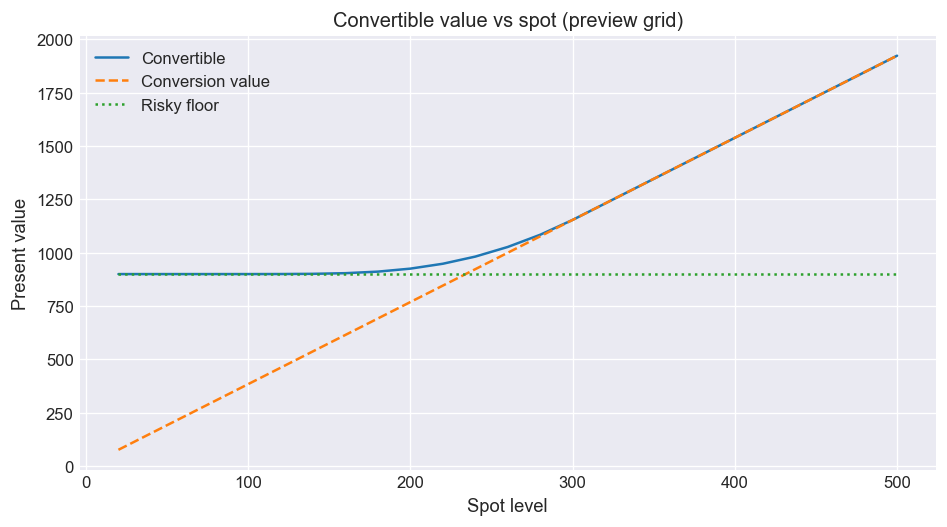

In [37]:
if RUN_HEAVY and best_calibration is not None:
    spots = np.linspace(20.0, 500.0, 25)
    values = []

    for s in spots:
        hazard_fn = lambda S: hazard_lambda(S, best_calibration["b"], best_calibration["p"])
        result = solve_convertible_cb(
            sigma=best_calibration["sigma"],
            hazard_profile=hazard_fn,
            r_fn=r_of,
            q_fn=lambda _t: DIVIDEND_YIELD,
            T=T_cb,
            N=NOTIONAL,
            CR=CONVERSION_RATIO,
            R_b=RECOVERY_BOND,
            S0_eval=s,
            n_space=320,
            n_time=900,
        )
        lam_spot = default_intensity_fcn(0.0, s, best_calibration["b"], best_calibration["p"])
        floor_val = approximate_risky_floor(lam_spot)
        values.append(
            {
                "S": s,
                "CB": result["price"],
                "Conversion": CONVERSION_RATIO * s,
                "Floor": floor_val,
            }
        )

    sweep_df = pd.DataFrame(values)
    if SAVE_ARTIFACTS:
        sweep_df.to_csv(ART_DIR / "cb_spot_sweep.csv", index=False)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(sweep_df["S"], sweep_df["CB"], label="Convertible")
    ax.plot(sweep_df["S"], sweep_df["Conversion"], label="Conversion value", linestyle="--")
    ax.plot(sweep_df["S"], sweep_df["Floor"], label="Risky floor", linestyle=":")
    ax.set_xlabel("Spot level")
    ax.set_ylabel("Present value")
    ax.set_title("Convertible value vs spot (preview grid)")
    ax.legend()
    fig.tight_layout()
else:
    print("RUN_HEAVY=False → spot sweep is disabled. Enable heavy mode for the full plot.")


In [38]:
if RUN_HEAVY:
    print("Heavy runs are enabled — expect longer runtimes for calibration and FD pricing.")
else:
    print("Heavy runs are disabled. Set RUN_HEAVY=True to execute calibration grids and PDE sweeps.")


Heavy runs are enabled — expect longer runtimes for calibration and FD pricing.
